# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.346107,True,10.061621
1,0.423382,False,-0.066451
2,1.580267,True,7.288788
3,0.687121,True,7.136655
4,0.285966,True,5.312043
...,...,...,...
995,0.749631,True,8.440484
996,0.674678,True,6.167290
997,1.709339,True,9.191946
998,1.978923,False,6.938018


<AxesSubplot:xlabel='v0'>

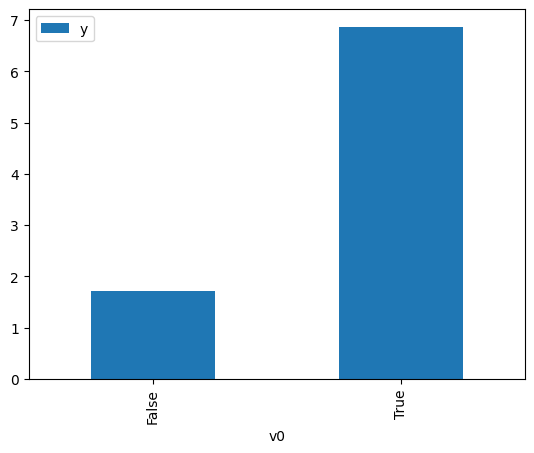

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

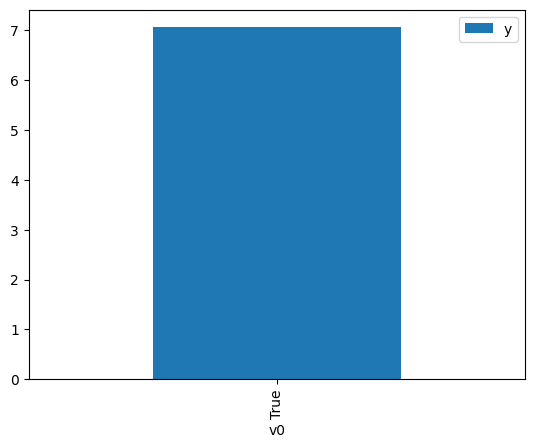

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.506402,False,3.805754,0.052863,18.916685
1,1.506402,False,3.805754,0.052863,18.916685
2,0.500416,False,-0.110381,0.245388,4.075177
3,0.194370,False,2.224381,0.357276,2.798957
4,-0.080901,False,-0.990128,0.473783,2.110672
...,...,...,...,...,...
995,1.176165,False,3.243801,0.090529,11.046211
996,1.129811,False,3.524367,0.097441,10.262640
997,1.037146,False,3.137144,0.112680,8.874673
998,1.358866,False,5.635056,0.067404,14.835892


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.267682,True,9.663402,0.921833,1.084795
1,-0.636702,True,3.940887,0.295518,3.383892
2,4.337642,True,15.357788,0.999609,1.000391
3,1.571427,True,10.260232,0.952558,1.049805
4,-1.251149,True,2.427442,0.125081,7.994835
...,...,...,...,...,...
995,1.316472,True,8.114695,0.927775,1.077848
996,1.234803,True,7.773848,0.917581,1.089822
997,1.516743,True,8.202760,0.948036,1.054812
998,2.695181,True,10.241695,0.993093,1.006955


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          2.553e+04
Date:                Tue, 23 Aug 2022   Prob (F-statistic):                        0.00
Time:                        11:55:43   Log-Likelihood:                         -1436.7
No. Observations:                1000   AIC:                                      2877.
Df Residuals:                     998   BIC:                                      2887.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4294      0.038     64.577      0.000       2.356       2.503
x2             4.9039      0.059     83.394      0.000       4.789       5.019
==============================================================================
Omnibus:                        3.314   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                3.126
Skew:                           0.087   Prob(JB):                        0.209
Kurtosis:                       2.788   Cond. No.                         3.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""